# Imports

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Functions

In [4]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    """
    The function takes the model, the split data and the name and returns the dataframe with
    the scores of the models with training and test data.
    """
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred_train = model.predict(X_train)
    logloss      = log_loss(y_train, y_pred_train)

    df_model_train = pd.DataFrame({'data'        : 'training',
                             'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss]})
    
    accuracy     = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    y_pred_test = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred_test)   # SVC & LinearSVC unable to use cvs

    df_model_test = pd.DataFrame({'data'        : 'test',
                             'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss]})   # timetaken: to be used for comparison later
    
    df_model = pd.concat([df_model_train, df_model_test], ignore_index=True)

    return df_model

In [5]:
def plot_feature_importances(model, df):
    """
    The function takes the model and the dataframe and returns graph showing the importance of
    the features.
    """
    names = df.columns[model.feature_importances_.argsort()]
    model.feature_importances_.sort()
    plt.figure(figsize=(15,15))
    n_features = len(names)
    plt.barh(range(n_features), np.sort(model.feature_importances_), align='center')
    plt.yticks(np.arange(n_features), names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

In [6]:
def results_defaut(main_model_results, compare_model_results_hyp):
    """
    Function takes main model results with default values and model to compare results after the
    hyperparameter tuning and returns the comparison of the results.
    """
    print(f'{main_model_results.iloc[1]["model"]} is giving us the F1 score of {round(main_model_results.iloc[1]["f1score"], 3)} on the test data.')

    if main_model_results.iloc[1]["f1score"] > compare_model_results_hyp.iloc[1]["f1score"]:
          print(f'{main_model_results.iloc[1]["model"]} improves the result from {compare_model_results_hyp.iloc[1]["model"]} (score: {round(compare_model_results_hyp.iloc[1]["f1score"], 3)})')
    else:
          print(f'{main_model_results.iloc[1]["model"]} does not imporve the score from {compare_model_results_hyp.iloc[1]["model"]} (score: {round(compare_model_results_hyp.iloc[1]["f1score"], 3)}')


In [7]:
def results_after_hyp(main_model_results_hyp, main_model_results, compare_model_results_hyp):
    """
    Function takes main model results before and after the hyperparameter tuning 
    and model to compare results after the hyperparameter tuning 
    and returns the comparison of the results.
    """
    print(f'{main_model_results_hyp.iloc[1]["model"]} is giving us the F1 score of {round(main_model_results_hyp.iloc[1]["f1score"], 3)} on the test data.')

    if main_model_results_hyp.iloc[1]["f1score"] > main_model_results.iloc[1]["f1score"]:
        print(f'Hyperparameter tuning imporved our score from {round(main_model_results.iloc[1]["f1score"], 3)} to {round(main_model_results_hyp.iloc[1]["f1score"], 3)}')
    else:
        print(f'Our score after the hyperparameter tuning changed from {round(main_model_results.iloc[1]["f1score"], 3)} to {round(main_model_results_hyp.iloc[1]["f1score"], 3)}')

    if main_model_results_hyp.iloc[1]["f1score"] > compare_model_results_hyp.iloc[1]["f1score"]:
          print(f'{main_model_results_hyp.iloc[1]["model"]} improves the result from {compare_model_results_hyp.iloc[1]["model"]} (score: {round(compare_model_results_hyp.iloc[1]["f1score"], 3)})')
    else:
          print(f'{main_model_results_hyp.iloc[1]["model"]} does not imporve the score from {compare_model_results_hyp.iloc[1]["model"]} (score: {round(compare_model_results_hyp.iloc[1]["f1score"], 3)})')

## Data

In this section, we will be working with the clean and transformed dataframe (errors and NaN values were handled in the previous step).

In [8]:
# Loading clean and transformed dataframe

#df = pd.read_csv('data/df_transformed.csv')

In [9]:
################# To delete this step when have the dataframe from sosa

# since don't have yeat the real df, will upload the old one

df = pd.read_csv('data/clean_tf.csv', sep=',', index_col=0)

df = df.fillna(method='ffill')
df = df.drop('Unnamed: 0', axis=1)

Investigating data to see what changes have to be done before moving to the modeling.

In [10]:
# Checking if imported data is correct

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,AnyPage,Visitor_isReturning,random
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,1.0,1.0,1.0,Returning_Visitor,0.0,False,1.0,1.0,0.228473
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,2.0,2.0,1.0,2.0,Returning_Visitor,0.0,False,2.0,1.0,0.222005
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,4.0,1.0,9.0,3.0,Returning_Visitor,0.0,False,1.0,1.0,0.775748
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,3.0,2.0,2.0,4.0,Returning_Visitor,0.0,False,2.0,1.0,0.337079
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,99.0,1.0,4.0,Returning_Visitor,1.0,False,10.0,1.0,0.064565


In [11]:
# Checking the types of the variables

df.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems           float64
Browser                    float64
Region                     float64
TrafficType                float64
VisitorType                 object
Weekend                    float64
Revenue                       bool
AnyPage                    float64
Visitor_isReturning        float64
random                     float64
dtype: object

From this short investigation, we have identified that there are several categorical variables that will need to be encoded before using data with the models.

# Prepare Training Data

## Data Transformation

A good technique for evaluating performance is generating a random values column. We're inserting random value column as measure of feature importance. If a feature has less score that this random generated column, it's a sign of its poor significance in our data.

In [ ]:
rand = [random.random() for i in range(len(df))]
df['random'] = rand

We are also eliminating 'PageValues' from the independent variables because (as identified in the previous steps) it is too dependent on the outcome and it will not be possible to use it in the prediction.

In [ ]:
df = df.drop('PageValues', axis=1)

## Data Encoding

We're encoding categorical variables to be able to use them in the models of machine learning.


### Label Encoder

We will be using the Label Encoder for the columns 'Revenue' and 'Weekend'. These columns have only two categories meaning that we don't need to create different columns to encode the values.

In [12]:
# Creating the instance of labelencoder
labelencoder = LabelEncoder()

# Assigning the columns
cols_label_enc = ['Revenue', 'Weekend']

# Creating labels for the columns
for col in cols_label_enc:
    df[col+'_enc'] = labelencoder.fit_transform(df[col])

In [13]:
print(f'Encoded Revenue values:\n{df.Revenue_enc.value_counts()}')
print(f'\nEncoded Weekend values:\n{df.Weekend_enc.value_counts()}')

Encoded Revenue values:
0    10422
1     1908
Name: Revenue_enc, dtype: int64

Encoded Weekend values:
0    9460
1    2870
Name: Weekend_enc, dtype: int64


Checking the value counts of these columns we can see that the values have been encoded to 0 (False) and 1 (True).

### OneHotEncoder

We will be using OneHotEncoder for 'Month', 'OperatingSystems', 'Region', 'TrafficType' and 'Browser' columns because they have more than two categories, therefore, additional columns have to be created.

In [14]:
appended_dfs = []

columns = ['Month', 'OperatingSystems', 'Region', 'Browser', 'TrafficType']

for col in columns:
    # Creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # Passing columns
    enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
    # Getting values for the names of the columns
    enc_df.columns = enc.get_feature_names()+col
    # Appenign all new dfs to one list
    appended_dfs.append(enc_df)
# Mergeing with the main df
df_encoded = df.join(appended_dfs) 
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,x0_4.0TrafficType,x0_5.0TrafficType,x0_6.0TrafficType,x0_8.0TrafficType,x0_9.0TrafficType,x0_10.0TrafficType,x0_11.0TrafficType,x0_13.0TrafficType,x0_20.0TrafficType,x0_99.0TrafficType
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Deleting the columns that were encoded:

In [15]:
cols_drop = ['Revenue', 'Weekend', 'Month', 'OperatingSystems', 'Region', 'Browser', 'TrafficType', 
             'VisitorType']
df_encoded.drop(columns=cols_drop, inplace=True)

Checking if the data has been encoded correctly:

In [16]:
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,x0_4.0TrafficType,x0_5.0TrafficType,x0_6.0TrafficType,x0_8.0TrafficType,x0_9.0TrafficType,x0_10.0TrafficType,x0_11.0TrafficType,x0_13.0TrafficType,x0_20.0TrafficType,x0_99.0TrafficType
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_encoded.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
AnyPage                    float64
Visitor_isReturning        float64
random                     float64
Revenue_enc                  int64
Weekend_enc                  int64
x0_AugMonth                float64
x0_DecMonth                float64
x0_FebMonth                float64
x0_JulMonth                float64
x0_JuneMonth               float64
x0_MarMonth                float64
x0_MayMonth                float64
x0_NovMonth                float64
x0_OctMonth                float64
x0_SepMonth                float64
x0_1.0OperatingSystems     float64
x0_2.0OperatingSystems     float64
x0_3.0OperatingSystems     float64
x0_4.0OperatingSyste

In [18]:
print(f'The shape of the encoded dataset is: {df_encoded.shape}')

The shape of the encoded dataset is: (12330, 60)


### Exporting encoded data to csv

In [19]:
df_encoded.to_csv("data/df_encoded.csv", index=True)

## Data Split

To be able to use data with the machine learning models we will need to split it to the independent variables (X) and target variable (y). 

Original dataset shape X: 12330, y: 12330

Original split between True and False:
0    10422
1     1908
Name: Revenue_enc, dtype: int64


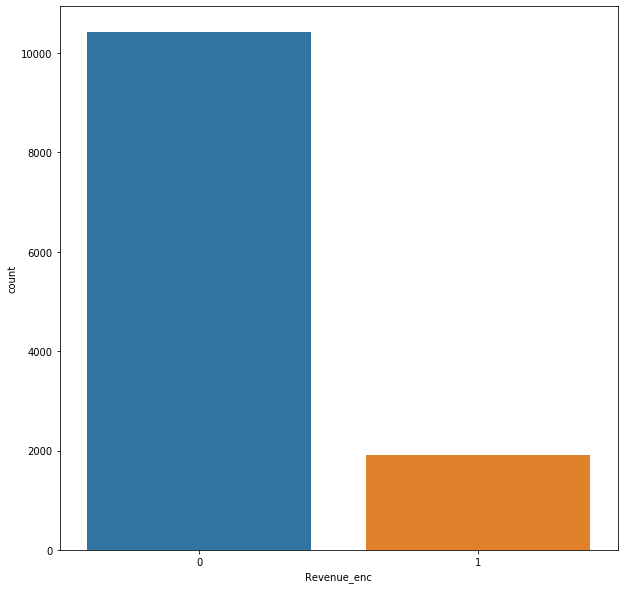

In [20]:
X = df_encoded.drop(columns=['Revenue_enc'])
y = df_encoded['Revenue_enc']

print(f'Original dataset shape X: {len(X)}, y: {len(y)}')
print(f'\nOriginal split between True and False:\n{y.value_counts()}')

sns.countplot(y)
plt.show()

## Data Balancing (Undersampling)

As identified in the EDA in the previous step, we have imbalanced data distribution, the observations in the class False are much higher than the observations in the class True.

Standard ML techniques such as Decision Tree and Logistic Regression have a bias towards the majority class, and they tend to ignore the minority class. They tend only to predict the majority class, hence, having major misclassification of the minority class in comparison with the majority class.

We will use the NearMiss, an undersampling technique for our dataset.

### NearMiss

This technique aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, it removes the instances of the majority class to increase the spaces between the two classes. This helps in the classification process.

Resampled dataset shape X: 3816, Y: 3816

Resampled split between True and False:
1    1908
0    1908
dtype: int64


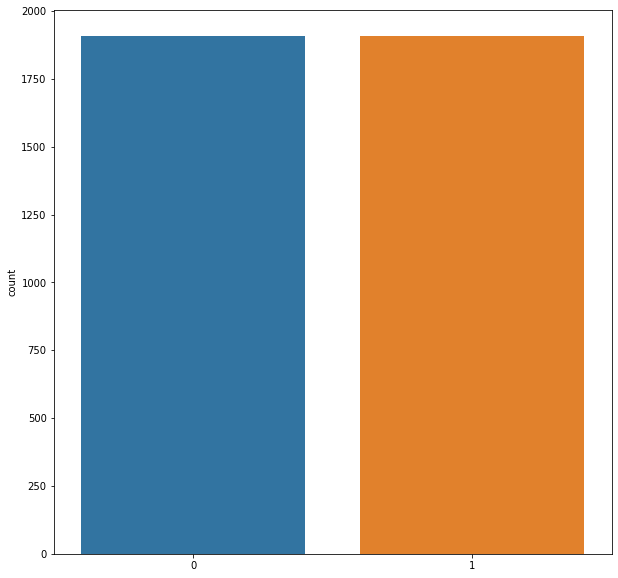

In [21]:
nr = NearMiss()
X, y = nr.fit_sample(X, y)

print(f'Resampled dataset shape X: {len(X)}, Y: {len(y)}')
print(f'\nResampled split between True and False:\n{pd.Series(y).value_counts()}')

sns.countplot(y)
plt.show()

## Scaling

Feature Scaling is a technique to standardize the independent variables present in the data in a fixed range. We will perform it to handle highly varying values of our dataset. If feature scaling is not done, a machine learning algorithm tends to weigh greater values, and consider smaller values as the lower values, regardless of the unit of the values.

### StandardScaler

We will be using the StandardScaler. It is a technique which re-scales a feature value so that it has distribution with 0 mean value and variance equals to 1.

In [22]:
std_scale = StandardScaler()

X = std_scale.fit_transform(X)

## Selecting test and train data

To be able to train and test our model on the different sets of the dataset, we will split the data into training and testing parts.

- With shuffle, we set to shuffle the data before splitting.
- With stratify, we choose to split the data stratifying via our target feature (y).

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, 
                                                    random_state=41)

# Modeling

We will be testing our data with 6 classification models:

- K-Nearest Neighbors
- Logistic Regression
- Decision Tree
- Random Forest
- Linear Support Vector Classification
- Gaussian Naive Bayes

We will focus our analysis to optimize the F1_score. When optimizing for F1_score we take both precision and recall into account. Trying to only optimize recall, the algorithm will predict most examples to belong to the positive class, but that will result in many false positives and, hence, low precision. On the other hand, trying to optimize precision, the model will predict very few examples as positive results (the ones with the highest probability), but recall will be very low.

## K-Nearest Neighbors

K-Nearest Neighbors is an algorithm by which an unclassified data point is classified based on its distance from known points.

The way that model decides how to classify the unknown point is by creating a circle with the point as the center. The size of the circle is set by choosing the number of neighbors. This setting does not refer to the actual size of the circle, however, it refers to how many neighboring points are to fall inside of the circle.

We will start our modeling with the K-Nearest Neighbors with the default number of neighbors (5).

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_test = knn.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
knn_results = baseline_report(knn, X_train, X_test, y_train, y_test, 'KNeighborsClassifier')
knn_results

Confussion Matrix for test data:
[[465 108]
 [141 431]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       573
           1       0.80      0.75      0.78       572

    accuracy                           0.78      1145
   macro avg       0.78      0.78      0.78      1145
weighted avg       0.78      0.78      0.78      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.758907,0.800830,0.725323,0.757512,0.848310,4.926762
1,test,KNeighborsClassifier,0.785203,0.806846,0.741220,0.770454,0.848949,7.511128


##### Results with default parameters

In [25]:
print(f'{knn_results.iloc[1]["model"]} is giving us the F1 score of {round(knn_results.iloc[1]["f1score"], 3)} on the test data.')

KNeighborsClassifier is giving us the F1 score of 0.77 on the test data.


### Hyperparameter Tuning

We will be using a GridSearchCV to choose the best parameters for our models. The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. 

We need to keep in mind that GridSearchCV has a very high computation cost if we want to try a bigger range of parameter values.

Another thing to mention is that n_jobs is set to -1. By setting n_jobs to -1, we are telling the computer to use all of it’s processors to perform the model.

##### GridSearchCV

Parameters that we will be checking:

**n_neighbors**: int, optional (default = 5). Number of neighbors to use by default for kneighbors queries.

We will be passing only the odd numbers as the possible values for the n_neighbors parameter. If you choose an even number, in the case of a tie vote, the decision on which class to assign will be done randomly when weights is set to uniform. By choosing an odd number, there are no ties.

**weights**: str or callable, optional (default = 'uniform'). Weight function used in prediction. Possible values: 

'uniform' : uniform weights. All points in each neighborhood are weighted equally. 

'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. 

[callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights. 

**metric**: string or callable, default 'minkowski'. The distance metric to use for the tree. The default metric is minkowski. We will be testing 'euclidean' metric, which distance function is sqrt(sum((x - y)^2)) and 'manhattan' metric, which function is sum(|x - y|).




In [26]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19],
              'weights': ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)

best_params_knn = grid.best_params_
print(best_params_knn)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s


{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    9.9s finished


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [27]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
knn_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'KNeighborsClassifier')
knn_results_hyp

Confussion Matrix for test data:
[[518  55]
 [128 444]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       573
           1       0.89      0.78      0.83       572

    accuracy                           0.84      1145
   macro avg       0.85      0.84      0.84      1145
weighted avg       0.85      0.84      0.84      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.828906,0.89069,0.759699,0.824785,0.922057,4.254333
1,test,KNeighborsClassifier,0.838429,0.89926,0.760381,0.823494,0.927050,5.520210


##### Results after the hyperparameter tuning

In [28]:
print(f'{knn_results_hyp.iloc[1]["model"]} is giving us the F1 score of {round(knn_results_hyp.iloc[1]["f1score"], 3)} on the test data.')

if knn_results_hyp.iloc[1]["f1score"] > knn_results.iloc[1]["f1score"]:
    print(f'Hyperparameter tuning improved our score from {round(knn_results.iloc[1]["f1score"], 3)} to {round(knn_results_hyp.iloc[1]["f1score"], 3)}')
else:
    print(f'Our score after the hyperparameter tuning changed from {round(knn_results.iloc[1]["f1score"], 3)} to {round(knn_results_hyp.iloc[1]["f1score"], 3)}')
    

KNeighborsClassifier is giving us the F1 score of 0.823 on the test data.
Hyperparameter tuning imporved our score from 0.77 to 0.823


## Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_test = logreg.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
logreg_results = baseline_report(logreg, X_train, X_test, y_train, y_test, 'LogisticRegression')
logreg_results

Confussion Matrix for test data:
[[540  33]
 [ 37 535]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       573
           1       0.94      0.94      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LogisticRegression,0.928490,0.946821,0.913173,0.929309,0.981915,2.068981
1,test,LogisticRegression,0.930073,0.942950,0.910755,0.930994,0.983265,2.111564


##### Results with default parameters

In [30]:
results_defaut(logreg_results, knn_results_hyp)

LogisticRegression is giving us the F1 score of 0.931 on the test data.
LogisticRegression improves the result from KNeighborsClassifier (score: 0.823)


### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**C**: float, default=1.0 Inverse of regularization strength. Must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

**penalty**: {'l1', 'l2', 'elasticnet', 'none'}, default='l2'. Used to specify the norm used in the penalization. The 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is only supported by the 'saga' solver. If 'none' (not supported by the liblinear solver), no regularization is applied.

**solver**: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'. Algorithm to use in the optimization problem. For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones. For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss; 'liblinear' is limited to one-versus-rest schemes.

‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

‘liblinear’ and ‘saga’ also handle L1 penalty

‘saga’ also supports ‘elasticnet’ penalty

‘liblinear’ does not support setting penalty='none'

**multi_class**: {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’. If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

In [31]:
c_values = list(10.0**np.arange(-3, 3))

param_grid = [{'C': c_values,
              'penalty': ['l2'],
              'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              'multi_class': ['ovr', 'warn']},
              {'C': c_values,
              'penalty': ['l1'],
              'solver' : ['liblinear', 'saga'],
              'multi_class': ['ovr', 'warn']}]

grid = GridSearchCV(LogisticRegression(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)

best_params_logreg = grid.best_params_
print(best_params_logreg)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   10.3s finished


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [32]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
logreg_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'LogisticRegression')
logreg_results_hyp

Confussion Matrix for test data:
[[549  24]
 [ 40 532]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       573
           1       0.96      0.93      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LogisticRegression,0.931114,0.952685,0.909444,0.928494,0.981526,2.146566
1,test,LogisticRegression,0.932800,0.949078,0.905614,0.932507,0.985545,1.930568


##### Results after the hyperparameter tuning

In [33]:
results_after_hyp(logreg_results_hyp, logreg_results, knn_results_hyp)

LogisticRegression is giving us the F1 score of 0.933 on the test data.
Hyperparameter tuning imporved our score from 0.931 to 0.933
LogisticRegression improves the result from KNeighborsClassifier (score: 0.823)


## Decision Tree

Decision trees learn how to best split the dataset into smaller and smaller subsets to predict the target value. The condition, or test, is represented as the 'leaf' (node) and the possible outcomes as 'branches' (edges). This splitting process continues until no further gain can be made or a preset rule is met, e.g. the maximum depth of the tree is reached.

In [34]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)

y_pred_test = dectree.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
dectree_results = baseline_report(dectree, X_train, X_test, y_train, y_test, 'DecisionTreeClassifier')
dectree_results

Confussion Matrix for test data:
[[519  54]
 [ 42 530]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       573
           1       0.91      0.93      0.92       572

    accuracy                           0.92      1145
   macro avg       0.92      0.92      0.92      1145
weighted avg       0.92      0.92      0.92      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,DecisionTreeClassifier,0.918008,0.911522,0.918411,0.913392,0.920996,9.992007e-16
1,test,DecisionTreeClassifier,0.913559,0.910023,0.905568,0.899173,0.899519,3.167356e+00


##### Results with default parameters

In [35]:
results_defaut(dectree_results, logreg_results_hyp)

DecisionTreeClassifier is giving us the F1 score of 0.899 on the test data.
DecisionTreeClassifier does not imporve the score from LogisticRegression (score: 0.933


### Feature importance

We're will be using a defined function to visualize the most important features from the Decision Tree model:

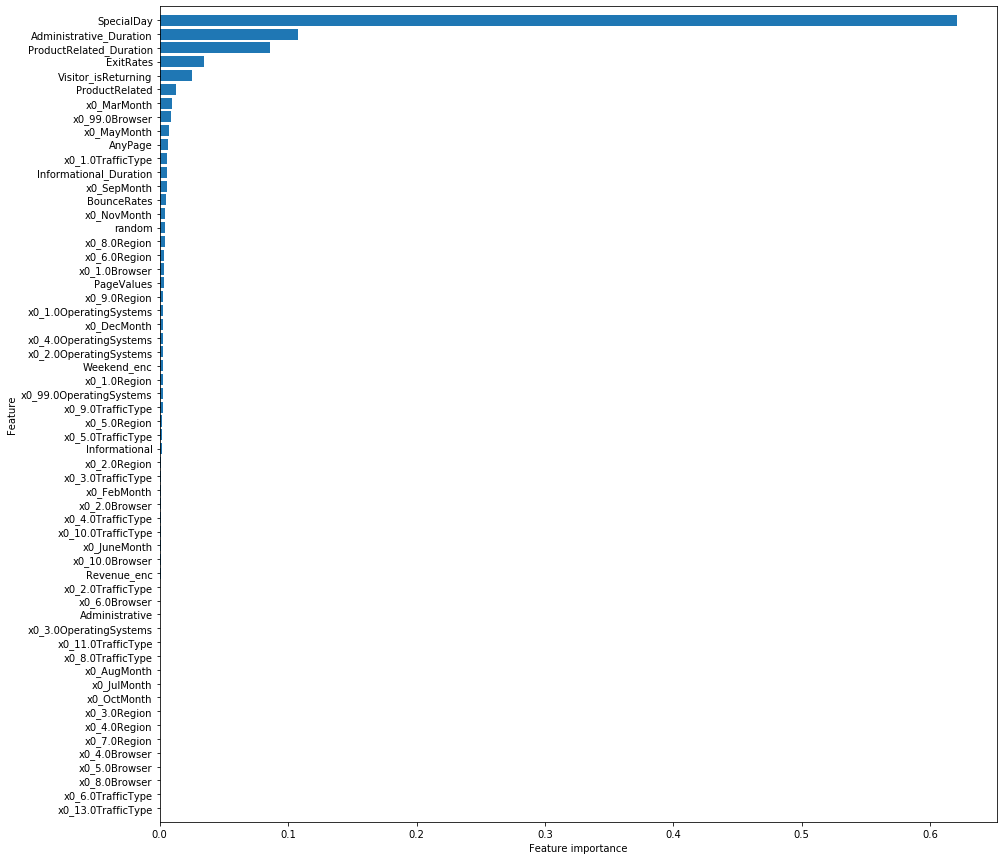

In [36]:
plot_feature_importances(dectree, df_encoded)
plt.savefig('feature_importance_dectree')

We can see that the most important feature is SpecialDay, other 4 features that highly impact the performance of the model are: Administrative_Duration, ProductRelated_Duration, ExitRates and Visitor_isReturing. After these 5 features we can see that the impact drops more significantly. 

The good practice is to remove the insignificant variables and run the model again, to avoid the overfitting. 

### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**criterion**: optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

**splitter**: string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

**max_depth**: int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting

In [37]:
depth = list(np.arange(2, 10))

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth' : depth}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_dectree = grid.best_params_
print(best_params_dectree)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.3s finished


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [38]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
dectree_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'DecisionTreeClassifier')
dectree_results_hyp

Confussion Matrix for test data:
[[536  37]
 [ 32 540]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       573
           1       0.94      0.94      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,DecisionTreeClassifier,0.912385,0.946875,0.907938,0.921866,0.968371,1.693978
1,test,DecisionTreeClassifier,0.924871,0.937182,0.916064,0.922531,0.953350,2.202064


##### Results after the hyperparameter tuning

In [39]:
results_after_hyp(dectree_results_hyp, dectree_results, logreg_results_hyp)

DecisionTreeClassifier is giving us the F1 score of 0.923 on the test data.
Hyperparameter tuning imporved our score from 0.899 to 0.923
DecisionTreeClassifier does not imporve the score from LogisticRegression (score: 0.933)


## Random Forest

Random forests construct many individual decision trees at training. Predictions from all trees are pooled to make the final prediction, the mode of the classes for classification or the mean prediction for regression. As they use a collection of results to make a final decision, they are referred to as Ensemble techniques.

In [40]:
from sklearn.ensemble import RandomForestClassifier

rfor = RandomForestClassifier()
rfor.fit(X_train, y_train)

y_pred_test = rfor.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
rfor_results = baseline_report(rfor, X_train, X_test, y_train, y_test, 'RandomForestClassifier')
rfor_results

Confussion Matrix for test data:
[[535  38]
 [ 44 528]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       573
           1       0.93      0.92      0.93       572

    accuracy                           0.93      1145
   macro avg       0.93      0.93      0.93      1145
weighted avg       0.93      0.93      0.93      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,RandomForestClassifier,0.931864,0.950582,0.910177,0.928689,0.980401,0.181035
1,test,RandomForestClassifier,0.930168,0.956099,0.912616,0.932128,0.980173,2.262388


##### Results with default parameters

In [41]:
results_defaut(rfor_results, dectree_results_hyp)

RandomForestClassifier is giving us the F1 score of 0.932 on the test data.
RandomForestClassifier improves the result from DecisionTreeClassifier (score: 0.923)


### Feature importance

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

False

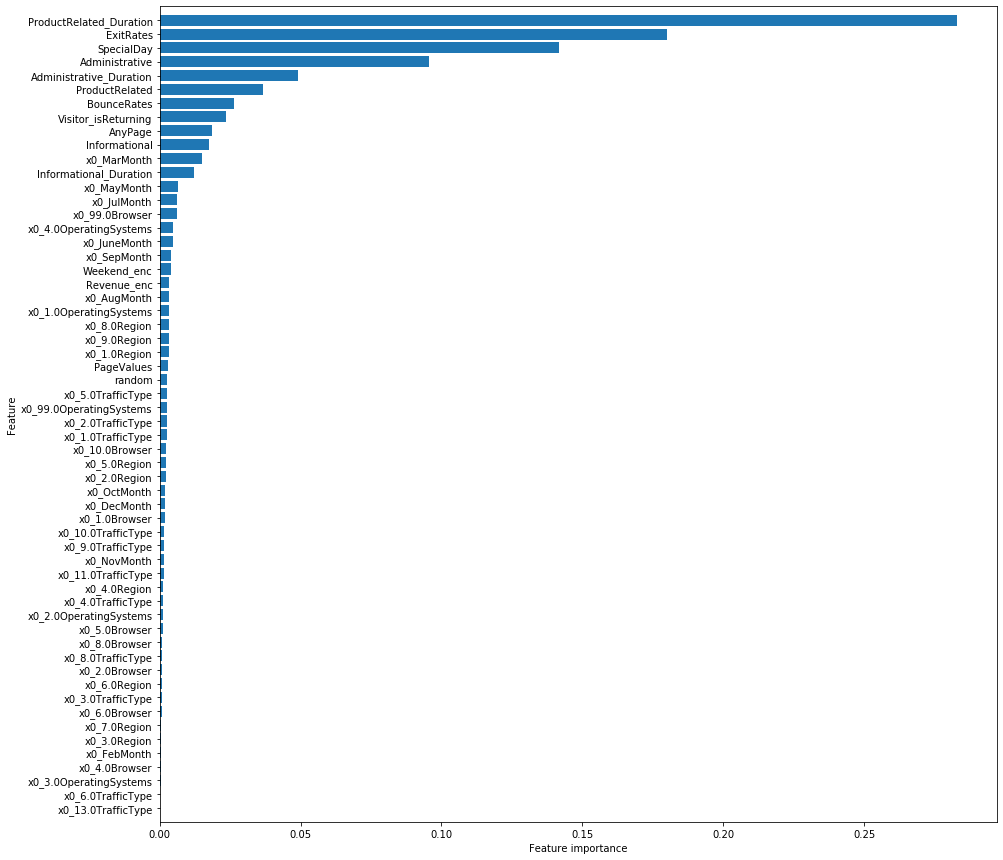

In [71]:
plot_feature_importances(rfor, df_encoded)
plt.savefig('feature_importance_rfor')


# feature = rfor.feature_importances_ < 0.05

# df_encoded.loc[:, feature]

# len(feature) == len(X)

We can see a slight difference in the feature selection from the features selected with Decision Tree. Here the importance of the SpecialDay is a lot lower. 

The randomness in building the random forest forces the algorithm to consider many possible explanations, the result being that the random forest captures a much broader picture of the data than a single tree.

The most important feature from the Random Forest is ProductRelated_Duration. Other 8 important features are: ProductRelated, SpecialDay, ExitRates, Administrative, Administrative_Duration, Bouncerates, InformationalDuration and Visitor_isReturning. 

We can choose to have a split of the features using the elbow principle or using the random feature. The logic behind the random feature is that: if the feature is less important than the random feature (with random values), it could be safely removed from the selection.

### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**n_estimators**: integer, optional (default=100). The number of trees in the forest. The default value of n_estimators changed from 10 to 100 in version 0.22.

**max_features**: int, float, string or None, optional (default=”auto”). The number of features to consider when looking for the best split:

If int, then consider max_features features at each split.

If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.

If “auto”, then max_features=sqrt(n_features).

If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

If “log2”, then max_features=log2(n_features).

If None, then max_features=n_features.

Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

**max_depth**: integer or None, optional (default=None). The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**criterion**: string, optional (default=”gini”). The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

In [43]:
param_grid = {'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_rfor = grid.best_params_
print(best_params_rfor)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   59.3s finished


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [44]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
rfor_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'RandomForestClassifier')
rfor_results_hyp

Confussion Matrix for test data:
[[543  30]
 [ 39 533]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       573
           1       0.95      0.93      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,RandomForestClassifier,0.934105,0.950037,0.921387,0.933729,0.986104,1.396558
1,test,RandomForestClassifier,0.934516,0.953480,0.926606,0.940627,0.987537,2.021065


##### Results after the hyperparameter tuning

In [45]:
results_after_hyp(rfor_results_hyp, rfor_results, dectree_results_hyp)

RandomForestClassifier is giving us the F1 score of 0.941 on the test data.
Hyperparameter tuning imporved our score from 0.932 to 0.941
RandomForestClassifier improves the result from DecisionTreeClassifier (score: 0.923)


## Linear Support Vector Classification

The objective of a Linear SVC (Support Vector Classifier) is to fit to the data provided, returning a 'best fit' hyperplane that divides or categorizes the data. After getting the hyperplane, you can then feed some features to the classifier to see what the 'predicted' class is. It has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples compared to SVC.

In [46]:
from sklearn.svm import LinearSVC

linearsvc = LinearSVC()
linearsvc.fit(X_train, y_train)

y_pred_test = linearsvc.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
linearsvc_results = baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')
linearsvc_results

Confussion Matrix for test data:
[[541  32]
 [ 38 534]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       573
           1       0.94      0.93      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LinearSVC,0.934481,0.953246,0.914674,0.933230,0.980285,1.978463
1,test,LinearSVC,0.931015,0.947636,0.928406,0.924754,0.984441,2.111563


##### Results with default parameters

In [47]:
results_defaut(linearsvc_results, rfor_results_hyp)

LinearSVC is giving us the F1 score of 0.925 on the test data.
LinearSVC does not imporve the score from RandomForestClassifier (score: 0.941


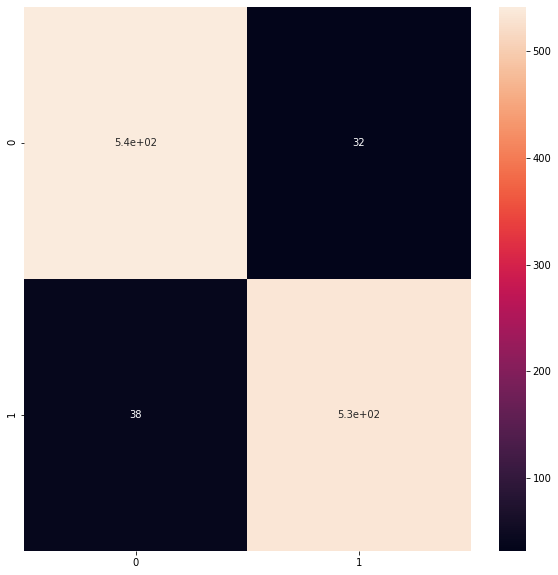

In [48]:
# Visualizing results

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)
plt.show()

### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**C**: float, optional (default=1.0). Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

**multi_class**: str, ‘ovr’ or ‘crammer_singer’ (default=’ovr’). Determines the multi-class strategy if y contains more than two classes. 

"ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

**penalty**: str, ‘l1’ or ‘l2’ (default=’l2’). Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

**loss**: str, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’). Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.

**dual**: bool, (default=True). Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.

In [49]:
c_values = list(10.0**np.arange(-3, 3))

param_grid = [{'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l1'],
              'loss': ['squared_hinge'],
              'dual': [0]},
              {'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l2'],
              'loss': ['squared_hinge'],
              'dual': [1]}]

grid = GridSearchCV(LinearSVC(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_linearsvc = grid.best_params_
print(best_params_linearsvc)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   42.0s finished


{'C': 0.1, 'dual': 0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [50]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
linearsvc_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'LinearSVC')
linearsvc_results_hyp

Confussion Matrix for test data:
[[544  29]
 [ 42 530]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       573
           1       0.95      0.93      0.94       572

    accuracy                           0.94      1145
   macro avg       0.94      0.94      0.94      1145
weighted avg       0.94      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LinearSVC,0.933731,0.953285,0.910179,0.929973,0.982561,2.030186
1,test,LinearSVC,0.934524,0.956965,0.919588,0.933821,0.987091,2.141726


##### Results after the hyperparameter tuning

In [51]:
results_after_hyp(linearsvc_results_hyp, linearsvc_results, rfor_results_hyp)

LinearSVC is giving us the F1 score of 0.934 on the test data.
Hyperparameter tuning imporved our score from 0.925 to 0.934
LinearSVC does not imporve the score from RandomForestClassifier (score: 0.941)


## Gaussian Naive Bayes

A Gaussian Naive Bayes algorithm is a special type of NB algorithm. It assumes that all the features are following a gaussian distribution i.e, normal distribution and that the value of a particular feature is independent of the value of any other feature, given the class variable. An advantage of naive Bayes is that it only requires a small number of training data to estimate the parameters necessary for classification. 

In [52]:
from sklearn.naive_bayes import GaussianNB

naive_b = GaussianNB()
naive_b.fit(X_train, y_train)

y_pred_test = naive_b.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
naive_b_results = baseline_report(naive_b, X_train, X_test, y_train, y_test, 'GaussianNB')
naive_b_results

Confussion Matrix for test data:
[[560  13]
 [ 64 508]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       573
           1       0.98      0.89      0.93       572

    accuracy                           0.93      1145
   macro avg       0.94      0.93      0.93      1145
weighted avg       0.94      0.93      0.93      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,GaussianNB,0.915011,0.951548,0.873484,0.910509,0.972569,2.754322
1,test,GaussianNB,0.924859,0.961011,0.884622,0.920755,0.973636,2.322704


##### Results with default parameters

In [53]:
results_defaut(naive_b_results, linearsvc_results_hyp)

GaussianNB is giving us the F1 score of 0.921 on the test data.
GaussianNB does not imporve the score from LinearSVC (score: 0.934


### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**var_smoothing** : float, optional (default=1e-9). Portion of the largest variance of all features that is added to variances for calculation stability.

In [54]:
smooth = list(10.0**np.arange(-9, -4))

param_grid = {'var_smoothing' : smooth}

grid = GridSearchCV(GaussianNB(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_naive_b = grid.best_params_
print(best_params_naive_b)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'var_smoothing': 1e-06}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


We now know the best parameters for our model. The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [55]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
naive_b_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'GaussianNB')
naive_b_results_hyp

Confussion Matrix for test data:
[[552  21]
 [ 54 518]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       573
           1       0.96      0.91      0.93       572

    accuracy                           0.93      1145
   macro avg       0.94      0.93      0.93      1145
weighted avg       0.94      0.93      0.93      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,GaussianNB,0.921011,0.946858,0.888476,0.917032,0.969637,2.625016
1,test,GaussianNB,0.931053,0.955117,0.889794,0.916157,0.966817,2.262380


##### Results after the hyperparameter tuning

In [56]:
results_after_hyp(naive_b_results_hyp, naive_b_results, linearsvc_results_hyp)

GaussianNB is giving us the F1 score of 0.916 on the test data.
Our score after the hyperparameter tuning changed from 0.921 to 0.916
GaussianNB does not imporve the score from LinearSVC (score: 0.934)


## Final model evaluation

Results of all models before hyperparameter tuning:

In [57]:
before_hyp = [knn_results, logreg_results, dectree_results, rfor_results, 
              linearsvc_results, naive_b_results]

final_results_before = pd.concat(before_hyp, ignore_index=True)
final_results_before

,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.758907,0.800830,0.725323,0.757512,0.848310,4.926762e+00
1,test,KNeighborsClassifier,0.785203,0.806846,0.741220,0.770454,0.848949,7.511128e+00
2,training,LogisticRegression,0.928490,0.946821,0.913173,0.929309,0.981915,2.068981e+00
3,test,LogisticRegression,0.930073,0.942950,0.910755,0.930994,0.983265,2.111564e+00
4,training,DecisionTreeClassifier,0.918008,0.911522,0.918411,0.913392,0.920996,9.992007e-16
5,test,DecisionTreeClassifier,0.913559,0.910023,0.905568,0.899173,0.899519,3.167356e+00
6,training,RandomForestClassifier,0.931864,0.950582,0.910177,0.928689,0.980401,1.810347e-01
7,test,RandomForestClassifier,0.930168,0.956099,0.912616,0.932128,0.980173,2.262388e+00
8,training,LinearSVC,0.934481,0.953246,0.914674,0.933230,0.980285,1.978463e+00
9,test,LinearSVC,0.931015,0.947636,0.928406,0.924754,0.984441,2.111563e+00


In [58]:
best_test_score_before = final_results_before.loc[final_results_before.data == 'test'].f1score.max()
best_test_model_before = final_results_before.loc[(final_results_before.data == 'test') & 
                                                  (final_results_before.f1score == 
                                                   best_test_score_before)].model.values[0]
print(f'The model with the best F1_score with the default parameters is {best_test_model_before}, score: {round(best_test_score_before, 3)}')

The model with the best F1_score with the default parameters is RandomForestClassifier, score: 0.932


Results of all models after hyperparameter tuning:

In [59]:
after_hyp = [knn_results_hyp, logreg_results_hyp, dectree_results_hyp, rfor_results_hyp, 
              linearsvc_results_hyp, naive_b_results_hyp]

final_results_after = pd.concat(after_hyp, ignore_index=True)
final_results_after

,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.828906,0.890690,0.759699,0.824785,0.922057,4.254333
1,test,KNeighborsClassifier,0.838429,0.899260,0.760381,0.823494,0.927050,5.520210
2,training,LogisticRegression,0.931114,0.952685,0.909444,0.928494,0.981526,2.146566
3,test,LogisticRegression,0.932800,0.949078,0.905614,0.932507,0.985545,1.930568
4,training,DecisionTreeClassifier,0.912385,0.946875,0.907938,0.921866,0.968371,1.693978
5,test,DecisionTreeClassifier,0.924871,0.937182,0.916064,0.922531,0.953350,2.202064
6,training,RandomForestClassifier,0.934105,0.950037,0.921387,0.933729,0.986104,1.396558
7,test,RandomForestClassifier,0.934516,0.953480,0.926606,0.940627,0.987537,2.021065
8,training,LinearSVC,0.933731,0.953285,0.910179,0.929973,0.982561,2.030186
9,test,LinearSVC,0.934524,0.956965,0.919588,0.933821,0.987091,2.141726


In [60]:
best_test_score_after = final_results_after.loc[final_results_after.data == 'test'].f1score.max()
best_test_model_after = final_results_after.loc[(final_results_after.data == 'test') & 
                                                (final_results_after.f1score == 
                                                 best_test_score_after)].model.values[0]
print(f'The model with the best F1_score after the hyperparameter tuning is {best_test_model_after}, score: {round(best_test_score_after, 3)}')

The model with the best F1_score after the hyperparameter tuning is RandomForestClassifier, score: 0.941


In [ ]:
## Make heatmap to draw conclusions